In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import pandas as pd
from scipy import ndimage, stats

# Set the device
if th.cuda.is_available():
    device = th.device("cuda")
    print(f"Using device {device}: {th.cuda.get_device_name()}")
elif th.backends.mps.is_available():
    device = th.device("mps")
    print(f"Using device {device}")
else:
    device = th.device("cpu")
    print(f"Using device {device}")

/Users/beepboop/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/beepboop/miniconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/beepboop/miniconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/beepboop/miniconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device mps


In [2]:
hyperparams = {
    "learning_rate": 2e-4,
    "batch_size": 64,
    "epochs": 150,
    "l1_lambda": 100,
    "adam_betas": (0.5, 0.999), # default values are (0.9, 0.999)
}

# Dataset

## Preparing the dataset

In [3]:
#TODO: Create functions to load the dataset, perform transformations, and split into training, test, and validation sets
#TODO: Make sure that not all images are loaded into memory at once, but rather are loaded as needed to prevent crashing

def load_train_test_image_pairs(dataset_path, dataset_name):
    pass

def load_validation_images(dataset_path, dataset_name):
    pass

transforms = [
    T.Resize([256, 256], interpolation=T.InterpolationMode.NEAREST),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomCrop(256),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #TOOD: Make sure this places values in [-1,1]
]

def prep_images():
    
    training_set = th.utils.data.Dataset()
    test_set = th.utils.data.Dataset()
    validation_set = th.utils.data.Dataset()
    
    return training_set, test_set, validation_set

## Running dataset construction code

In [4]:
training_set, test_set, validation_set = prep_images()

training_set = th.utils.data.DataLoader(
    dataset=training_set,
    batch_size=hyperparams['batch_size']
    )

test_set = th.utils.data.DataLoader(
    dataset=test_set,
    batch_size=hyperparams['batch_size']
    )

validation_set = th.utils.data.DataLoader(
    dataset=validation_set,
    batch_size=hyperparams['batch_size']
    )

# Models

## Discriminator

In [5]:
class DownModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        return x      
    
class ZeroPadModule(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x = F.pad(x, (1, 1, 1, 1), mode='constant', value=0)
        return x

class Discriminator(nn.Module):
    
    def __init__(self, DEBUG=False):
        super().__init__()
        self.DEBUG = DEBUG
        
        self.DownLayers = nn.Sequential(
            DownModule(6, 64),
            DownModule(64, 128),
            DownModule(128, 256),
            ZeroPadModule(),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            ZeroPadModule(),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid() #NOTE: Not actually in the paper, but required for the BCELoss (limits values to [0,1]). This produces a valid probability tensor.
        )
        
    def forward(self, x: th.Tensor, y: th.Tensor) -> th.Tensor:
        """Forward pass of the discriminator

        Args:
            x (th.Tensor): Raw underwater image
            y (th.Tensor): Enhanced underwater image

        Returns:
            th.Tensor: Output tensor measuring the realness of the input images
        """
        
        z = th.concatenate((x, y), dim=1)
        
        # Input tensor shape
        if self.DEBUG:
            print("Input tensor shape:")
            print(z.shape)
        
        for layer in self.DownLayers:
            z = layer(z)
            if self.DEBUG:
                print(z.shape)
        
        return z
    
#discriminator = Discriminator(DEBUG=True).to(device)

#sample = th.rand(1, 3, 256, 256, device=device)
#clone = sample.clone()
#output = discriminator(sample, clone)

## Generator / Autoencoder

In [6]:
class EncoderModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        return x      

class FeatureMapModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.lrelu(x)
        return x      

class DecoderModule(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.5):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.relu(x)
        return x
    
class OutputModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        x = self.deconv(x)
        return x

class Autoencoder(nn.Module):
    """
    Autoencoder model for image generation

    A residual autoencoder model for image generation. 
    The final model will be an image-to-image translation model
    that enhances underwater images.
    """
    def __init__(self, DEBUG=False):
        super().__init__()
        self.DEBUG = DEBUG

        self.EncoderLayers = nn.ModuleList([
            EncoderModule(3, 64),
            EncoderModule(64, 128),
            EncoderModule(128, 256),
            EncoderModule(256, 512),
            EncoderModule(512, 512),
            EncoderModule(512, 512),
            EncoderModule(512, 512),
            FeatureMapModule(512, 512),
        ])
        
        self.DecoderLayers = nn.ModuleList([
            DecoderModule(512, 512),
            DecoderModule(1024, 512),
            DecoderModule(1024, 512),
            DecoderModule(1024, 512, dropout_prob=0.0),
            DecoderModule(1024, 256, dropout_prob=0.0),
            DecoderModule(512, 128, dropout_prob=0.0),
            DecoderModule(256, 64, dropout_prob=0.0),
        ])
        
        self.OutputLayer = OutputModule(128, 3)
        self.sigmoid = nn.Sigmoid() #NOTE: Not actually in the paper, but required to limit values to [0,1]. This produces a valid (float) image tensor.

        
    def forward(self, x, z):
        """Forward pass for the autoencoder model.

        Args:
            x (th.Tensor): Input image tensor
            z (th.Tensor): Noise tensor

        Returns:
            th.Tensor: Output image tensor
        """

        #TODO: Figure out precisely how the noise tensor is used. Tentaively we add them together. Paper is not clear.
        x = x + z

        # Store the activations of the encoder layers for skip connections
        layer_outputs = []
        
        if self.DEBUG:
            print("Starting forward pass")
            print(x.shape)
        
        # Encoder pass
        for i in range(len(self.EncoderLayers)):
            x = self.EncoderLayers[i](x)
            if i < len(self.EncoderLayers) - 1:
                layer_outputs.append(x)
            if self.DEBUG:
                print(x.shape)
        
        if self.DEBUG:
            print("Encoding complete")
            print(x.shape)
        
        # Checking the shapes of the stored activations
        #[print("Stored activations: ",x.shape) for x in layer_outputs]
        
        # Decoder pass      
        for i in range(len(self.DecoderLayers)):
            
            if i != 0:
                # Get the appropriate encoder activation
                s = layer_outputs.pop()
                
                # If the shapes match, concatenate the activations
                if x.shape == s.shape:
                    x = th.cat((x, s), 1)
                    
                else:
                    print("Error, shapes do not match")
                    print("X:", x.shape)
                    print("S:", s.shape)
                    return th.tensor([])

            # Pass the concatenated activations through the decoder layer
            x = self.DecoderLayers[i](x)
            if self.DEBUG:
                print(x.shape)
                 
        if self.DEBUG:
            print("Decoding complete")
        
        # Perform the final deconvolution
        x = th.cat((x, layer_outputs.pop()), 1)
        x = self.OutputLayer(x)
        x = self.sigmoid(x)
        
        if self.DEBUG:
            print("Is layer_outputs empty:", len(layer_outputs) == 0)
            print(x.shape)
            print("Output complete")
            
        return x
    
#TODO: Create a noise generator that can be used to add noise to the input images using the correct generation procdure.
 
#generator = Autoencoder(DEBUG=True).to(device)

#sample = th.rand(1, 3, 256, 256, device=device)
#noise = th.rand(1, 3, 256, 256, device=device)
#output = generator(sample, noise)

# Training Loop

## Defining the loop

In [7]:
from IPython.display import clear_output

def train_loop(dataloader, discriminator, generator, d_optimizer, g_optimizer, device, epochs=150, l1_lambda=100):
    
    loss_stats = pd.DataFrame(columns=["Epoch","d_loss", "g_loss", "g_GAN_loss", "g_L1_loss"])
    
    # Define the loss functions
    d_real_loss = th.nn.BCELoss()
    d_gan_loss = th.nn.BCELoss()
    g_gan_loss = th.nn.BCELoss()
    g_l1_loss = th.nn.L1Loss()
    
    #TODO: We might need to do some pre-training individually for the discriminator and generator. Double check the paper.
            
    for epoch in range(epochs):

        for batch, (x, y) in enumerate(dataloader):
                
            x, y = x.to(device), y.to(device)
            noise = th.rand(x.shape).to(device) #TODO: Verify that the noise is generated correctly
            
            #========================#
            # Discriminator training #
            #========================#
            
            # Zero the parameter gradients
            d_optimizer.zero_grad()
            
            # Forward pass
            z = generator(x, noise).detach() 
            d_real = discriminator(x, y)
            d_fake = discriminator(x, z)
            
            # Compute the loss
            drl = d_real_loss(d_real, th.ones_like(d_real))
            dgl = d_gan_loss(d_fake, th.zeros_like(d_fake))
            
            d_loss = drl + dgl
            
            # Backward pass
            d_loss.backward()
            
            # Update weights
            d_optimizer.step() #TODO: Check if this needs to be moved to after g_loss.backward()
            
            #====================#
            # Generator training #
            #====================#
            
            # Zero the parameter gradients
            g_optimizer.zero_grad()
            
            # Forward pass
            z = generator(x, noise)
            d_fake = discriminator(x, z).detach()
            
            # Compute the loss
            ggl = g_gan_loss(d_fake, th.ones_like(d_fake))
            gl1 = g_l1_loss(z, y)
            
            g_loss = ggl + l1_lambda * gl1
            
            # Backward pass
            g_loss.backward()
            
            # Update weights
            g_optimizer.step()
            
            #===================#
            # Cleanup memory   #
            #===================#
            #TODO: Verify that this is necessary and that it works as intended
            #del x, y, noise, z, d_real, d_fake
            
        # Print the loss statistics
        clear_output(wait=True)
        print(f"Epoch {epoch}, batch {batch}, d_loss: {d_loss.item():.2f}, g_loss: {g_loss.item():.2f}")
            
        # Save the loss statistics
        loss_stats = pd.concat(
            [loss_stats, pd.DataFrame(
                {
                "Epoch": epoch,
                "d_loss": d_loss.item(), 
                "g_loss": g_loss.item(), 
                "g_GAN_loss": ggl.item(), 
                "g_L1_loss": gl1.item()
                }, index=[0])
                ]
            )
        
    return loss_stats

## Random noise to test loop

In [8]:
# Generate 2 batches of random images of dimensions (3, 256, 256)
size = 32
batch1 = th.rand(size, 3, 256, 256, device=device)
batch2 = th.rand(size, 3, 256, 256, device=device)

# Create a dataloader
dataloader = th.utils.data.DataLoader(
    th.utils.data.TensorDataset(batch1, batch2), 
    batch_size=hyperparams["batch_size"],
    shuffle=True    
    )

# Sample a batch from the dataloader
#sample = next(iter(dataloader))

# Display the shape of the sample
#print(sample[0].shape, sample[1].shape)

## Running the loop

Description of various GAN training problems: 
- https://developers.google.com/machine-learning/gan/problems
- https://arxiv.org/pdf/2005.00065.pdf

In [9]:
train_set = dataloader

generator = Autoencoder().to(device)
discriminator = Discriminator().to(device)

# Generate a random image and noise tensor to test the generator while it is still untrained
rand_image = th.rand(1, 3, 256, 256, device=device)
rand_noise = th.rand(1, 3, 256, 256, device=device)

output = generator(rand_image, rand_noise)

# Plot the input, image pair on different subplots
fig, ax = plt.subplots(1, 2)
ax[0].imshow(rand_image.squeeze().permute(1, 2, 0).detach().cpu().numpy())
ax[1].imshow(output.squeeze().permute(1, 2, 0).detach().cpu().numpy())
plt.show()

d_optimizer = optim.Adam(
    discriminator.parameters(), 
    lr=hyperparams["learning_rate"],
    betas=hyperparams["adam_betas"],
    maximize=True,
)

g_optimizer = optim.Adam(
    generator.parameters(), 
    lr=hyperparams["learning_rate"],
    betas=hyperparams["adam_betas"],
    maximize=False,
)

loss_stats = train_loop(
    train_set, 
    discriminator, 
    generator, 
    d_optimizer, 
    g_optimizer, 
    device, 
    epochs=2,#hyperparams["epochs"], 
    l1_lambda=hyperparams["l1_lambda"]
    )

display(loss_stats)

Epoch 1, batch 0, d_loss: 1.49, g_loss: 31.70


,Epoch,d_loss,g_loss,g_GAN_loss,g_L1_loss
0,0,1.419783,32.335888,0.580153,0.317557
0,1,1.493813,31.701660,0.397805,0.313039


### Plotting traing results

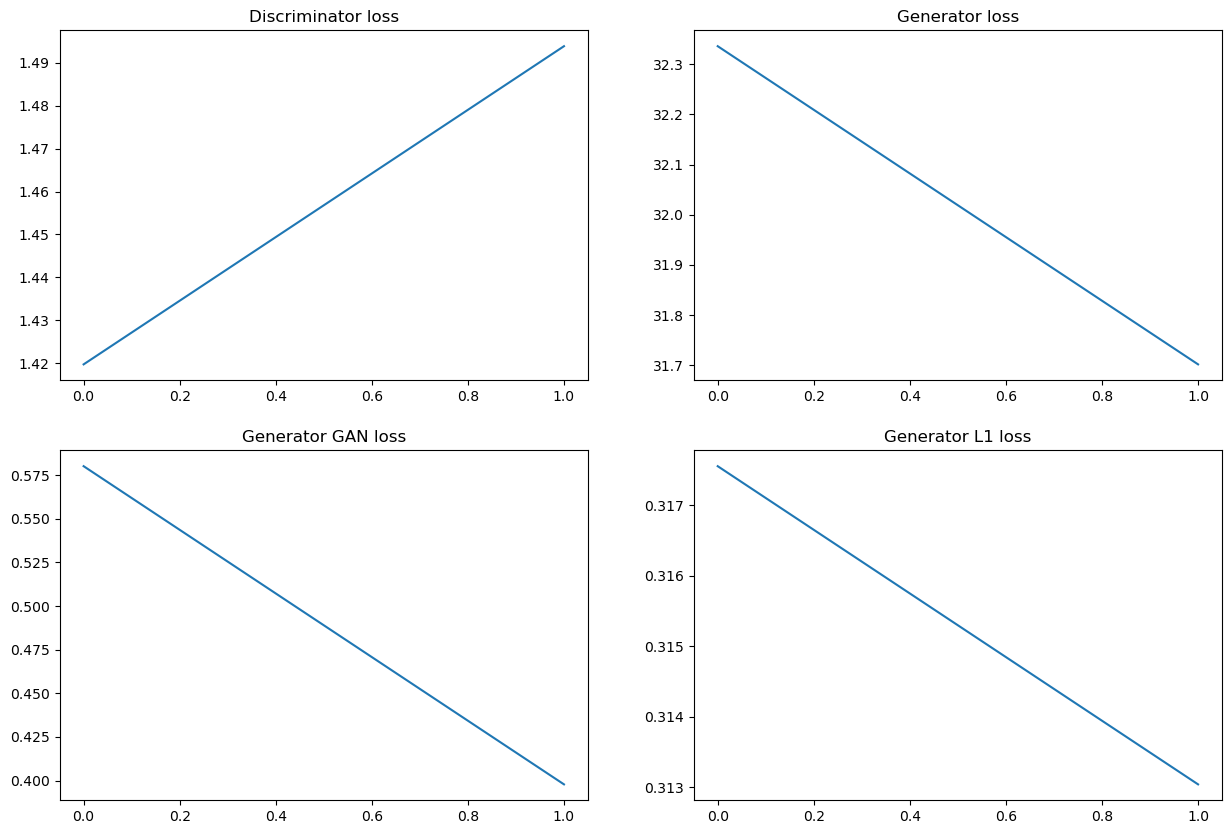

In [10]:
# Plot the loss statistics on different subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(loss_stats["Epoch"], loss_stats["d_loss"])
axs[0, 0].set_title("Discriminator loss")
axs[0, 1].plot(loss_stats["Epoch"], loss_stats["g_loss"])
axs[0, 1].set_title("Generator loss")
axs[1, 0].plot(loss_stats["Epoch"], loss_stats["g_GAN_loss"])
axs[1, 0].set_title("Generator GAN loss")
axs[1, 1].plot(loss_stats["Epoch"], loss_stats["g_L1_loss"])
axs[1, 1].set_title("Generator L1 loss")
plt.show()


### Testing image generation

tensor(1.0000, device='mps:0') tensor(1.0000, device='mps:0')
tensor(0.9994, device='mps:0')


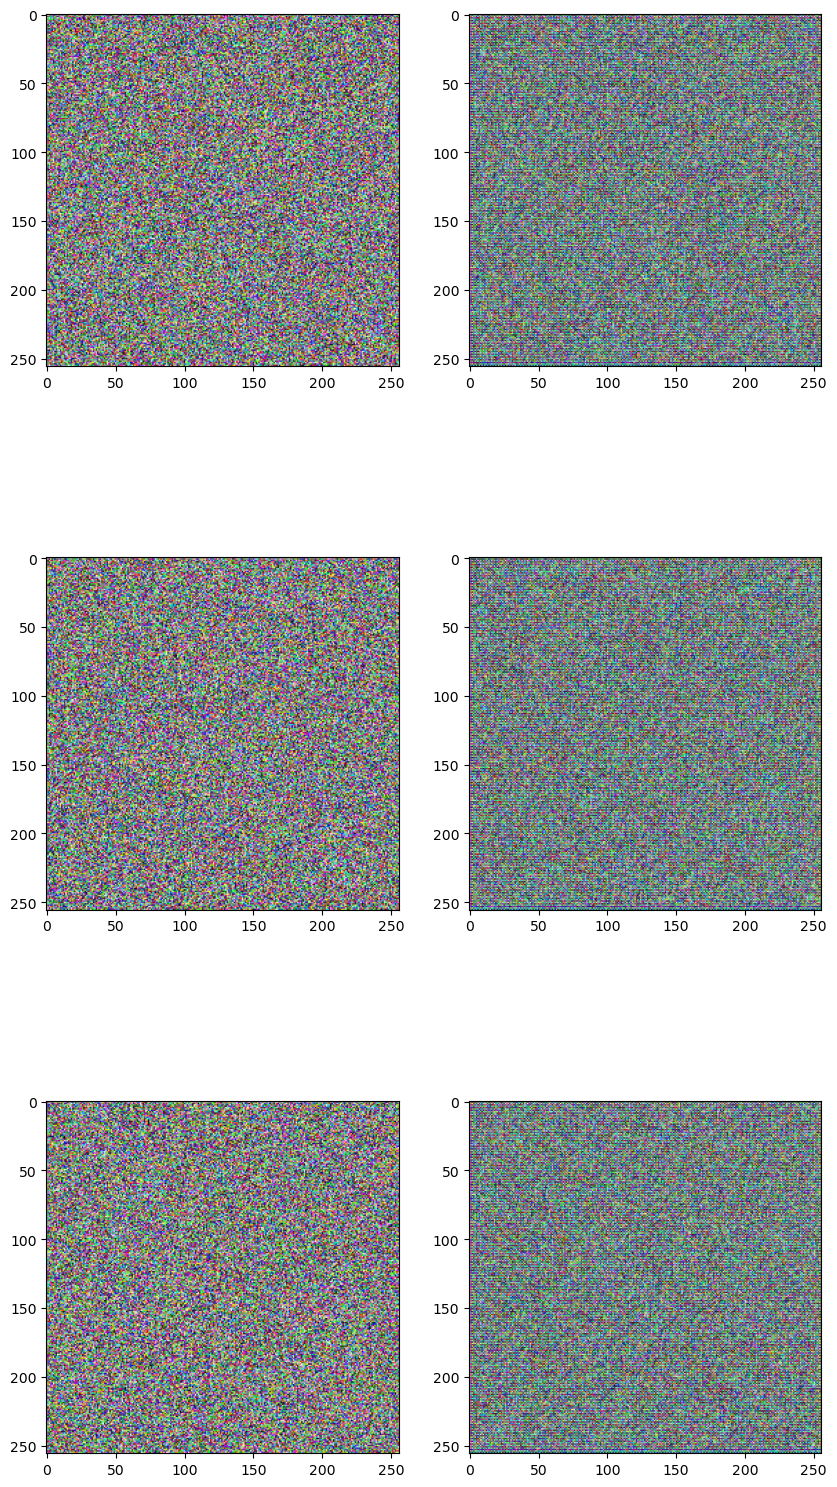

In [11]:
# Disable gradient computation
with th.no_grad():
# Generate 10 random images using 2 noise tensors
    noise1 = th.rand(10, 3, 256, 256, device=device)
    noise2 = th.rand(10, 3, 256, 256, device=device)

    # Print the max value of the noise tensors
    print(noise1.max(), noise2.max())

    # Generate 10 enhanced images
    enhanced_images = generator(noise1, noise2)

    # Print the max value of the enhanced images
    print(enhanced_images.max())

    # Plot the original and enhanced images
    fig, axs = plt.subplots(3, 2, figsize=(10, 20))
    for i in range(3):
        axs[i, 0].imshow(noise1[i].permute(1, 2, 0).cpu().detach().numpy())
        axs[i, 1].imshow(enhanced_images[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

# Model evaluation

## Setting model to evaluation mode

In [12]:
# Set the model to evaluation mode
generator.eval()
discriminator.eval()

Discriminator(
  (DownLayers): Sequential(
    (0): DownModule(
      (conv): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (1): DownModule(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (2): DownModule(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (3): ZeroPadModule()
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7

## Defining the metrics

All metrics as implemented support multibatch processing. That is to say they support tensor input on the form:

[n, c=3, w, h] where n i the number of samples per batch. c is the number of colour channels. w and h are width/height respectively.

This may make code readability somewhat reduced.

### The UIQM rabbithole

UIQM is surprisingly complex. The different submetrics are appropriately broken down into separate functions.

In [13]:
def PSNR(x, y):
    """Peak Signal-to-Noise Ratio (PSNR)

    Args:
        x (np.ndarray): Image tensor, generated
        y (np.ndarray): Image tensor, ground truth

    Returns:
        float: PSNR value
    """
    # Maximum possible pixel value
    MAX = 1.0
    
    n, c, w, h = x.shape
    
    # Flattening each image, while retaining batch axis
    x = np.reshape(x, (n, c * w * h))
    y = np.reshape(y, (n, c * w * h))
    
    # Take the mean of the x-y difference along the batch axis
    mean = np.mean((x - y) ** 2, axis=1)
    
    # Compute the PSNR
    psnr = 10 * np.log10(MAX / mean)
    
    return psnr

def SSIM(x, y):
    """Structural Similarity Index Measure (SSIM)
    
    Args:
        x (np.ndarray): Image tensor, generated
        y (np.ndarray): Image tensor, ground truth

    Returns:
        float: SSIM value
    """
    # Maximum possible pixel value
    L = 1.0
    
    # Constants
    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2
    
    # Compute the mean of x and y along the channel, width, and height axes
    mu_x = np.mean(x, axis=(1,2,3))
    mu_y = np.mean(y, axis=(1,2,3))
    
    # Create a n, c, w, h tensor of the mean of x and y
    mu_x_b = np.broadcast_to(mu_x[:, np.newaxis, np.newaxis, np.newaxis], x.shape)
    mu_y_b = np.broadcast_to(mu_y[:, np.newaxis, np.newaxis, np.newaxis], y.shape)
    
    # Compute the variance and covariance of x and y
    sigma_x = np.mean((x - mu_x_b) ** 2, axis=(1, 2, 3))
    sigma_y = np.mean((y - mu_y_b) ** 2, axis=(1, 2, 3))
    
    sigma_xy = np.mean((x - mu_x_b) * (y - mu_y_b), axis=(1, 2, 3))
    
    # Compute the numerator and denominator of the SSIM
    num = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    den = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

    # Take the elementwise ratio of the numerator and denominator to obtain the SSIM
    ssim = num / den

    return ssim

def UIQM(x):
    """Underwater Image Quality Measure (UIQM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UIQM value
    """
    
    # Constants, as per the Sea-Pix-GAN paper
    c1 = 0.0282
    c2 = 0.2953
    c3 = 3.5753
    
    # Compute the UICM, UISM, and UIConM
    uicm = UICM(x)
    uism = UISM(x)
    uiconm = UIConM(x)
    
    return c1 * uicm + c2 * uism + c3 * uiconm

def UICM(x):
    """Underwater Image Colorfulness Measure (UICM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UICM value
    """
    # Extract the R, G, and B channels of all images in batch
    R = x[:,0, :, :]
    G = x[:,1, :, :]
    B = x[:,2, :, :]
    
    # Flatten the channels for batch
    n, w, h = R.shape
    R = np.reshape(R, (n, w * h))
    G = np.reshape(G, (n, w * h))
    B = np.reshape(B, (n, w * h))
    
    # Set alpha
    alpha = 0.1
    
    # Create the RG and YB channels
    RG = R - G
    YB = 0.5 * (R + G) - B
    
    # Compute the alpha trimmed distribution along each image
    aRG = stats.trimboth(RG, alpha, axis=1)
    aYB = stats.trimboth(YB, alpha, axis=1)
    
    # Compute the mean along each image
    mean_aRG = np.mean(aRG, axis=1)
    mean_aYB = np.mean(aYB, axis=1)
        
    # Compute the alpha trimmed standard deviation along each image
    std_aRG = np.sum((RG - mean_aRG[:, np.newaxis]) ** 2, axis=1) / (w * h - 1)
    std_aYB = np.sum((YB - mean_aYB[:, np.newaxis]) ** 2, axis=1) / (w * h - 1)
    
    std_aRG = np.sqrt(std_aRG)
    std_aYB = np.sqrt(std_aYB)
        
    # Constants, as per HVSIUIQM paper
    c1 = -0.0282
    c2 = 0.1586
    
    # Compute the 2 terms of the UICM
    term_1 = np.sqrt(mean_aRG ** 2 + mean_aYB ** 2) 
    term_2 = np.sqrt(std_aRG ** 2 + std_aYB ** 2) #TODO: can std be converted to variance to save computation?
    
    return c1 * term_1 + c2 * term_2

def UISM(x):
    """Underwater Image Sharpness Measure (UISM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UISM value
    """
    #=======================#
    # Edge detection filter #
    #=======================#
    
    # Run the image through a Sobel filter, along the x and y axes respectively. 
    x_grad = ndimage.sobel(x, axis=0)
    y_grad = ndimage.sobel(x, axis=1)
    
    # Then compute the magnitude of the gradients (hypotenuse of the two gradients)
    filtered_x = np.hypot(x_grad, y_grad)
    
    #=========================#
    # Enhancement measurement #
    #=========================#
    
    # Compute Enhancement Measure Estimation (EME) for each channel using the filtered image
    EME_R = EME(filtered_x[:,0, :, :])
    EME_G = EME(filtered_x[:,1, :, :])
    EME_B = EME(filtered_x[:,2, :, :])
    
    # Compute the weighted EME, using standard RGB channel weights
    lambda_R = 0.299
    lambda_G = 0.587
    lambda_B = 0.114
    
    return lambda_R * EME_R + lambda_G * EME_G + lambda_B * EME_B

def EME(x):
    """Enhancement Measure Estimation (EME)

    Args:
        x (np.ndarray): Image tensor, sobel filtered
        
    Returns:
        float: EME value
    """
    #TODO: What should the block size be? Unclear given paper (the one with the looong name)
    # Set the k1 and k2 constants as width and height of the image. n is the number of images in the batch
    n, k1, k2 = x.shape

    norm_const = 2 / (k1 * k2)
    
    EME = 0
    
    for i in range(k1):
        for j in range(k2):
            
            # Find max and min values in the block
            max_val = np.max(x[:, i:i+k1, j:j+k2])
            min_val = np.min(x[:, i:i+k1, j:j+k2])
            
            # Compute the local contrast
            local_contrast = np.log(max_val / min_val)
            
            EME += local_contrast
            
    return norm_const * EME

def UIConM(x):
    """Underwater Image Contrast Measure (UIConM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UIConM value
    """
    # RGB channel weights
    lambda_R = 0.299
    lambda_G = 0.587
    lambda_B = 0.114
    
    # Exract the intensity of the image, using standard RGB channel weights
    I = lambda_R * x[:,0, :, :] + lambda_G * x[:,1, :, :] + lambda_B * x[:,2, :, :]
    
    # Compute the logAMEE(Intensity)
    logamee = logAMEE(I)
    
    return logamee

def logAMEE(x):
    """Logarithmic Agaian Measure of Enhancement by Engropy (logAMEE)

    Args:
        x (np.ndarray): Image tensor, weighted intensity

    Returns:
        float: logAMEE value
    """
    # Define the PLIP operators #TODO: Double-check that these are in fact the correct operations
    add = lambda x,y: x + y - x * y         # circle-plus operator
    mul = lambda x,y: x * y                 # circle-multiply operator
    diff = lambda x,y: (x - y) / (1 - y)    # Theta operator
    
    # Define k1 and k2 as the width and height of the image
    n, k1, k2 = x.shape #TODO: Once again, what should the block size actually be? Check the paper again.
    
    
    # Define the constants
    norm_const = 1 / (k1 * k2)
    
    logamee = 0
    
    for i in range(k1):
        for j in range(k2):
            
            # Extract the block
            block = x[:, i:i+k1, j:j+k2]
            
            # Find the maximum and minimum values in the block
            max_val = np.max(block)
            min_val = np.min(block)
            
            I_diff = diff(max_val, min_val)
            I_add = add(max_val, min_val)
            
            ratio = I_diff / I_add
            
            logamee += ratio * np.log(ratio)
            
    return norm_const * logamee
    
def get_metrics(test_data, generator, DEBUG=False):
    # Set the frame size according to the debug mode    
    frame_size = 500 if not DEBUG else 10
    
    # Initialize the metrics dataframe
    metrics = pd.DataFrame(columns=["PSNR", "SSIM", "UIQM"])
    
    # While the length of metrics is < 500, keep sampling 
    # batches from the test data and computing the metrics
    while len(metrics) < frame_size:
        
        print(f"Metric samples computed: {len(metrics)}")
        
        # Disable gradient computation
        with th.no_grad():
            
            x, y = next(iter(test_data))
            
            x = x.to(device)
            y = y.detach().cpu().numpy()
            
            noise = th.rand(x.shape, dtype=th.float32).to(device)
            
            enhanced = generator(x, noise).detach().cpu().numpy()
            
            psnr = PSNR(y, enhanced)
            ssim = SSIM(y, enhanced)
            uiqm = UIQM(enhanced)
            
            batch_metrics = pd.DataFrame(
                {
                "PSNR": psnr, 
                "SSIM": ssim, 
                "UIQM": uiqm
                }
                )
            
            metrics = pd.concat(
                [metrics, batch_metrics]
                )
            
    # Discard any rows beyond the 500th
    metrics = metrics.head(frame_size)
        
    return metrics

## Getting the test metrics

In [14]:
#TODO: Replace the random noise with the actual test data
test_data = th.utils.data.DataLoader(th.utils.data.TensorDataset(batch1, batch2), batch_size=hyperparams["batch_size"])

raw_metrics = get_metrics(test_data, generator, DEBUG=True)

summary = pd.DataFrame(columns=["Mean", "Std"])

summary.loc["PSNR"] = [raw_metrics["PSNR"].mean(), raw_metrics["PSNR"].std()]
summary.loc["SSIM"] = [raw_metrics["SSIM"].mean(), raw_metrics["SSIM"].std()]
summary.loc["UIQM"] = [raw_metrics["UIQM"].mean(), raw_metrics["UIQM"].std()]

display(raw_metrics.head())

display(summary)

Metric samples computed: 0


/var/folders/2c/tfb9hf8d6p90y0twm0jk3ncm0000gn/T/ipykernel_93853/1984061023.py:314: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat(


,PSNR,SSIM,UIQM
0,10.328559,0.011830,4.294822
1,10.324397,0.008890,4.294820
2,10.309000,0.008666,4.294824
3,10.322213,0.010203,4.294819
4,10.334867,0.011608,4.294823


,Mean,Std
PSNR,10.321248,0.008212
SSIM,0.010233,0.001233
UIQM,4.294823,0.000002


# Saving the model

In [15]:
# Path to the model weights
path = "./rsc/model_weights/"
discriminator_path = path + "discriminator.pth"
generator_path = path + "generator.pth"

# Create the directory if it does not exist
import os
if not os.path.exists(path):
    os.makedirs(path)

# Save model weights for discriminator and generator
th.save(discriminator.state_dict(), discriminator_path)
th.save(generator.state_dict(), generator_path)